In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import datetime
import os

In [2]:
df = pd.read_csv('./data/Crop_recommendation.csv')
df

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee


In [3]:
features = df.iloc[:, :-1].values
labels = df.iloc[:, -1].values

In [4]:
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)
num_classes = len(np.unique(labels))

# Convert the features and labels to PyTorch tensors
features = torch.tensor(features, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)

# Normalize the features to have zero mean and unit variance
mean = features.mean(dim=0)
std = features.std(dim=0)
features = (features - mean) / std

In [5]:
features[0]

tensor([ 1.0686, -0.3445, -0.1017, -0.9354,  0.4726,  0.0433,  1.8099])

In [6]:
# Save the mean and standard deviation as separate arrays
np.savez("./model/normalization/normalization.npz", mean=mean, std=std)

In [7]:
with open("./model/pkl_files/encoder.pkl", "wb") as file:
    pickle.dump(encoder, file)

In [8]:
# Define a custom PyTorch dataset to wrap the features and labels
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

In [9]:
dataset = CustomDataset(features, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [10]:
class Net_64_128_64(nn.Module):
    def __init__(self, input_size,num_classes):
        super(Net_64_128_64, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_classes)


    def forward(self, x):
        x = F.selu(self.fc1(x))
        x = F.selu(self.fc2(x))
        x = F.selu(self.fc3(x))
        x = self.fc4(x)
        return F.softmax(x)


In [11]:
# Define the network hyperparameters
input_size = 7
num_classes = 22

# Initialize the network
net = Net_64_128_64(input_size, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# Train the network
train_losses = []
val_losses = []
EPOCH = 100
train_accuracies = []
val_accuracies = []

In [12]:
for epoch in range(EPOCH):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dataset):
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_dataset)
    train_losses.append(train_loss)
    with torch.no_grad():
        val_loss = 0.0
        for inputs, labels in val_dataset:
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        val_loss /= len(val_dataset)
        val_losses.append(val_loss)
    if epoch % 10 == 9:
        print(f'Epoch {epoch+1}/{EPOCH}: train loss: {train_loss:.4f} val loss: {val_loss:.4f}')

print('Finished training')


/var/folders/fh/5bt91c7d1hddmv3ctr03l5nm0000gn/T/ipykernel_97738/925164282.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 10/100: train loss: 2.2130 val loss: 2.2103
Epoch 20/100: train loss: 2.1859 val loss: 2.1877
Epoch 30/100: train loss: 2.1787 val loss: 2.1829
Epoch 40/100: train loss: 2.1752 val loss: 2.1832
Epoch 50/100: train loss: 2.1738 val loss: 2.1806
Epoch 60/100: train loss: 2.1726 val loss: 2.1801
Epoch 70/100: train loss: 2.1711 val loss: 2.1812
Epoch 80/100: train loss: 2.1711 val loss: 2.1802
Epoch 90/100: train loss: 2.1712 val loss: 2.1782
Epoch 100/100: train loss: 2.1708 val loss: 2.1785
Finished training


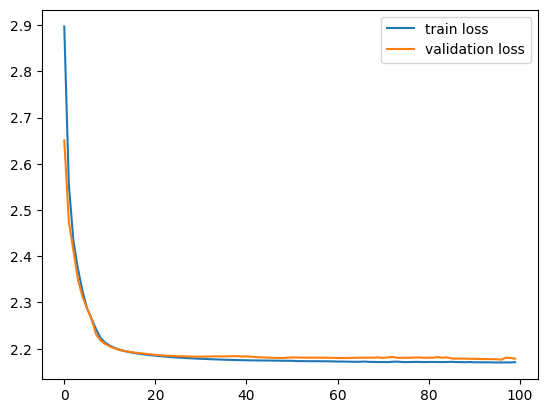

In [13]:
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()
plt.show()

In [14]:
model_name = str(datetime.datetime.now()).replace(' ','-').replace(':','-').replace('.','-') + '.hdf5'
file_name = f'./model/{model_name}'
if not os.path.exists('./model/'):
    os.mkdir('./model/')
    print("creating model dir")

In [15]:
torch.save(net.state_dict(), file_name)

In [16]:
model = Net_64_128_64(input_size,num_classes)
model.load_state_dict(torch.load('./model/baseline/baseline.hdf5'))

<All keys matched successfully>

In [17]:
# Calculate the accuracy
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in train_dataset:
        outputs = model(inputs)
        predicted = outputs.argmax() 
        # print(predicted, labels)
        total += 1
        correct += (predicted == labels)
        # print(predicted)

accuracy = 100 * correct / total
print(f'Accuracy of the network on the train: {accuracy:.2f}%')


Accuracy of the network on the train: 99.32%


/var/folders/fh/5bt91c7d1hddmv3ctr03l5nm0000gn/T/ipykernel_97738/925164282.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


In [21]:
# Calculate the accuracy
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_dataset:
        # print("Inputs:",inputs)
        outputs = model(inputs)
        predicted = outputs.argmax() 
        # print(predicted, labels)
        total += 1
        correct += (predicted == labels)
        # dec_labels= encoder.inverse_transform(np.array([predicted,labels]))
        # print(f"pred: {dec_labels[0]}, real: {dec_labels[1]}")
        # print(predicted)

accuracy = 100 * correct / total
print(f'Accuracy of the network on the validation: {accuracy:.2f}%')

Accuracy of the network on the validation: 99.77%


/tmp/ipykernel_70473/925164282.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


In [5]:
from model import net
import torch
import pickle
import numpy as np


def predict_crop(nitrogen, phosphorous, potassium, temperature, humidity, ph, rainfall):
    return get_prediction((nitrogen, phosphorous, potassium, temperature, humidity, ph, rainfall))


def get_prediction(x):
    model = net.Net_64_128_64(7, 22)
    model.load_state_dict(torch.load('model/baseline/baseline.hdf5'))
    normalization = np.load("model/normalization/normalization.npz")
    mean = normalization["mean"]
    std = normalization["std"]
    print(x)
    input_vector = torch.tensor(x, dtype=torch.float32)
    input_vector = (input_vector - mean) / std

    # print(input_vector.double())

    prediction = model(input_vector)

    with open("model/pkl_files/encoder.pkl", "rb") as file:
        encoder = pickle.load(file)

    predicted = prediction.argmax().item()
    encoded_labels = encoder.inverse_transform(np.array([predicted]))

    # DEBUG
    # print("Encoded labels:", encoded_labels)

    return encoded_labels


In [7]:
print(predict_crop(40,42,43,20.87974371,42.00274423,6.502985292000001,202.9355362))

(40, 42, 43, 20.87974371, 42.00274423, 6.502985292000001, 202.9355362)
['coffee']


/Users/admin/Pictures/ai_crop_prediction /model/net.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)
